<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensoFlow Part 1: Feature extraction

In [1]:
# Are we running a GPU
!nvidia-smi

Tue Dec 14 13:20:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading the data

In [2]:
# Get data (10% of the food classes from Food101)
import zipfile

# Download the data
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-12-14 13:20:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   114MB/s    in 1.4s    

2021-12-14 13:20:09 (114 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} and {len(filenames)} in the folder {dirpath}.")

There are 2 and 0 in the folder 10_food_classes_10_percent.
There are 10 and 0 in the folder 10_food_classes_10_percent/train.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/pizza.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/ramen.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/grilled_salmon.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/sushi.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/hamburger.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/chicken_wings.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/steak.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/chicken_curry.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/ice_cream.
There are 0 and 75 in the folder 10_food_classes_10_percent/train/fried_rice.
There are 10 and 0 in the folder 10_food_classes_10_percent/test.
There are 0 and 250 in the folder 10_fo

## Creating data loaders

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model is running)

Callbacks are extra functionalities you can add to your models to be performed during or after training. Some examples are below:
* Tracking experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20211214-132022
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.8931 - accuracy: 0.3773 - val_loss: 1.1838 - val_accuracy: 0.6348
Epoch 2/5
24/24 [==============================] - 22s 935ms/step - loss: 0.8652 - accuracy: 0.7533 - val_loss: 0.8409 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 22s 930ms/step - loss: 0.6124 - accuracy: 0.8293 - val_loss: 0.7740 - val_accuracy: 0.7480
Epoch 4/5
24/24 [==============================] - 22s 942ms/step - loss: 0.4760 - accuracy: 0.8787 - val_loss: 0.7189 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 22s 937ms/step - loss: 0.3831 - accuracy: 0.9067 - val_loss: 0.6935 - val_accuracy: 0.7692


In [14]:
# Let's create function to plot our loss curves
import matplotlib.pyplot as plt

# Plot validation and training curves
def plot_loss_curves(history):
  """
  Return seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  
  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

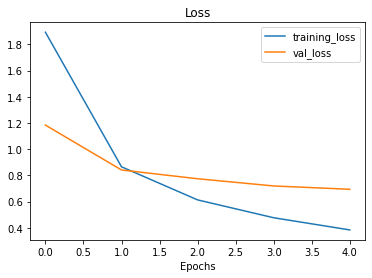

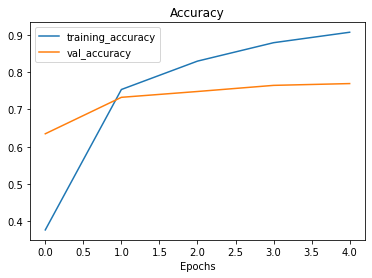

In [15]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model